In [6]:
import galsim
import numpy as np
from matplotlib.figure import Figure
from matplotlib.backends.backend_agg import FigureCanvasAgg
import matplotlib.animation as anim
from astropy.utils.console import ProgressBar
import warnings
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

seed = 1
argr0_500 = 0.2 #fried parameter at 500nm 
nlayers = 6 #num atmospheric layer
time_step = 0.03 #increment time steps for advancing phase screens
exptime = 3 # total time to integrate
screen_size = 102.4 #size of atmospheric screen
screen_scale = 0.1 #reso of atmospheric screen
max_speed = 20 #max wind speed
x = 0 #x coor of psf
y = 0 #y coor of psf
lam = 700 #wavelen
diam =4.0 #size of telescope pupil
obscuration = 0 #linear fractional obscration of the pupil
nstruts = 0 #num strurts supporting secondary obscruration
strut_thick = 0.05 #thickness of struts as fraction of aperture diam
strut_angle = 0 #starting angle of 1st strut
psf_nx = 512*2 #output psf image dimension
psf_scale = 0.005 # scale of psf output in ''
accumulate = False
pad_factor = 1 #factor to pad psf interpolating image to avoid aliasing
oversampling = 1 #factor to oversample psf interpolated image
psf_vmax = 0.0003 #vmax kwarg for psf image
wf_vmax = 50 #vmax kwarg for wavefront image
outfile = "test1.mp4"
accumulateint = True

#initiate random num
rng = galsim.BaseDeviate(seed)
u = galsim.UniformDeviate(rng)

#set altitude of each screen and its weight
Ellerbroek_alts = [0.0, 2.58, 5.16, 7.73, 12.89, 15.46]  # km
Ellerbroek_weights = [0.652, 0.172, 0.055, 0.025, 0.074, 0.022]
Ellerbroek_interp = galsim.LookupTable(Ellerbroek_alts, Ellerbroek_weights,interpolant='linear')
#create altitude with chosen num of layers
alts = np.max(Ellerbroek_alts)*np.arange(nlayers)/(nlayers-1)
#find corresponding weights from table
weights = Ellerbroek_interp(alts)  # interpolate the weights
weights /= sum(weights)  # and renormalize

#set wind speed and dir for each screen
spd = []  # Wind speed in m/s
dirn = [] # Wind direction in radians
r0_500 = [] # Fried parameter in m at a wavelength of 500 nm
for i in range(nlayers):
    spd.append(u()*max_speed) 
    dirn.append(u()*360*galsim.degrees) 
    r0_500.append(argr0_500*weights[i]**(-3./5))
    print("Adding layer at altitude {:5.2f} km with velocity ({:5.2f}, {:5.2f}) m/s, "
          "and r0_500 {:5.3f} m."
          .format(alts[i], spd[i]*dirn[i].cos(), spd[i]*dirn[i].sin(), r0_500[i]))
atm = galsim.Atmosphere(r0_500=r0_500, speed=spd, direction=dirn, altitude=alts, rng=rng,
                            screen_size=screen_size, screen_scale=screen_scale)



#field angle at which to compute psf
theta = (x*galsim.arcmin, y*galsim.arcmin)

#aperture of pupil
aper = galsim.Aperture(diam=diam, lam=lam, obscuration=obscuration,
                           nstruts=nstruts, strut_thick=strut_thick,
                           strut_angle=strut_angle*galsim.degrees,
                           screen_list=atm, pad_factor=pad_factor,
                           oversampling=oversampling)


Adding layer at altitude  0.00 km with velocity ( 0.08, -4.13) m/s, and r0_500 0.255 m.
Adding layer at altitude  3.09 km with velocity ( 6.61, -6.62) m/s, and r0_500 0.618 m.
Adding layer at altitude  6.18 km with velocity ( 0.86, 16.40) m/s, and r0_500 1.300 m.
Adding layer at altitude  9.28 km with velocity ( 0.28,  1.58) m/s, and r0_500 1.365 m.
Adding layer at altitude 12.37 km with velocity (10.01,  9.02) m/s, and r0_500 0.979 m.
Adding layer at altitude 15.46 km with velocity (-8.78, -16.90) m/s, and r0_500 1.945 m.


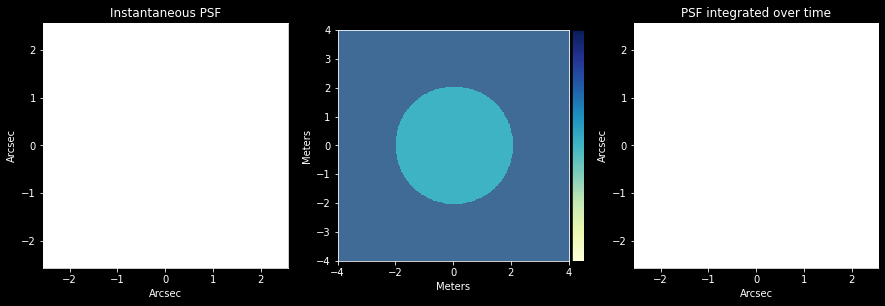

In [7]:
#create Fig frame
metadata = dict(title='Wavefront Movie', artist='Matplotlib')
writer = anim.FFMpegWriter(fps=15, bitrate=5000, metadata=metadata)
fig, (psf_inst_ax,wf_ax,psf_intg_ax) = plt.subplots(nrows=1,ncols=3, figsize=(15, 4.5))
FigureCanvasAgg(fig)

# Axis for the inst PSF
fig.set_facecolor("k")
psf_inst_ax.set_xlabel("Arcsec")
psf_inst_ax.set_ylabel("Arcsec")
psf_inst_im = psf_inst_ax.imshow(np.ones((128, 128), dtype=np.float64), animated=True,
               vmin=0.0, vmax=psf_vmax, cmap='hot',
               extent=np.r_[-1, 1, -1, 1]*0.5*psf_nx*psf_scale)
psf_inst_ax.set_title("Instantaneous PSF")

# Axis for the intg PSF
psf_intg_ax.set_xlabel("Arcsec")
psf_intg_ax.set_ylabel("Arcsec")
psf_intg_im = psf_intg_ax.imshow(np.ones((128, 128), dtype=np.float64), animated=True,
               vmin=0.0, vmax=psf_vmax, cmap='hot',
               extent=np.r_[-1, 1, -1, 1]*0.5*psf_nx*psf_scale)
psf_intg_ax.set_title("PSF integrated over time")

# Axis for the wavefront image on the right.
wf_ax.set_xlabel("Meters")
wf_ax.set_ylabel("Meters")
wf_im = wf_ax.imshow(np.ones((128, 128), dtype=np.float64), animated=True,
                     vmin=-wf_vmax, vmax=wf_vmax, cmap='YlGnBu',
                     extent=np.r_[-1, 1, -1, 1]*0.5*aper.pupil_plane_size)

divider = make_axes_locatable(wf_ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(wf_im, cax=cax, orientation='vertical')


# Overlay an alpha-mask on the wavefront image showing which parts are actually illuminated.
ilum = np.ma.masked_greater(aper.illuminated, 0.5)
wf_ax.imshow(ilum, alpha=0.4, extent=np.r_[-1, 1, -1, 1]*0.5*aper.pupil_plane_size)

# Color items white to show up on black background
for ax in [psf_inst_ax, wf_ax, psf_intg_ax]:
    for _, spine in ax.spines.items():
        spine.set_color('w')
    ax.title.set_color('w')
    ax.xaxis.label.set_color('w')
    ax.yaxis.label.set_color('w')
    ax.tick_params(axis='both', colors='w')


etext = psf_inst_ax.text(0.05, 0.92, '', transform=psf_inst_ax.transAxes)
etext.set_color('w')

nstep = int(exptime / time_step)
t0 = 0.0


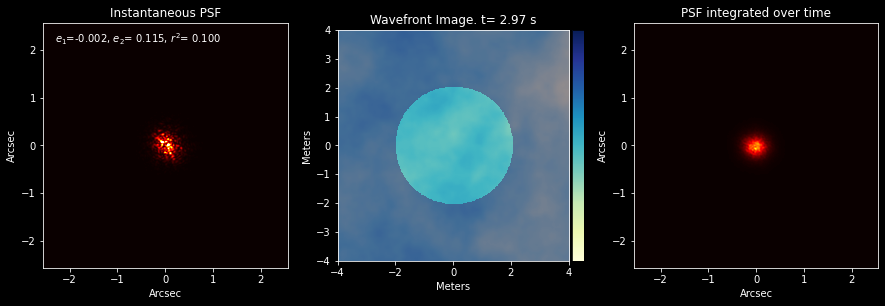

In [3]:
#store final image
psf_inst_img_sum = galsim.ImageD(psf_nx, psf_nx, scale=psf_scale)
psf_intg_img_sum = galsim.ImageD(psf_nx, psf_nx, scale=psf_scale)

for i in range(nstep):
    #create GSobjects
    wf = atm.wavefront(aper.u, aper.v, t0, theta=theta) * 2*np.pi/lam  # radians
    psfinst = atm.makePSF(lam=lam, theta=theta, aper=aper,
                      t0=t0, exptime=time_step)
    psfintg = atm.makePSF(lam=lam, theta=theta, aper=aper,
                      t0=t0, exptime=time_step)
    
    #draw and update images
    
    #inst frame
    psf_inst_img0 = psfinst.drawImage(nx=psf_nx, ny=psf_nx, scale=psf_scale)
    if accumulate:
        psf_inst_img_sum += psf_inst_img0
        psf_inst_img_f = psf_inst_img_sum/(i+1)
    else:
        psf_inst_img_f = psf_inst_img0

    #intg frame
    psf_intg_img0 = psfintg.drawImage(nx=psf_nx, ny=psf_nx, scale=psf_scale)
    if accumulateint:
        psf_inst_img_sum += psf_intg_img0
        psf_intg_img_f = psf_inst_img_sum/(i+1)
    else:
        psf_intg_img_f = psf_intg_img0

    
    # Calculate simple estimate of size and ellipticity
    e = galsim.utilities.unweighted_shape(psf_inst_img0)

    # Update t0 for the next movie frame.
    t0 += time_step

    # Matplotlib code updating plot elements
    wf_im.set_array(wf)
    wf_ax.set_title("Wavefront Image. t={:5.2f} s".format(i*time_step))
    
    psf_inst_im.set_array(psf_inst_img_f.array)
    
    psf_intg_im.set_array(psf_intg_img_f.array)
    
    etext.set_text("$e_1$={:6.3f}, $e_2$={:6.3f}, $r^2$={:6.3f}".format(
            e['e1'], e['e2'], e['rsqr']*psf_scale**2))

fig   




In [4]:
psf_inst_img_f.array

array([[9.7318367e-09, 9.0762171e-09, 8.2330338e-09, ..., 6.6659669e-09,
        8.1540055e-09, 9.4150101e-09],
       [9.2217762e-09, 8.1965652e-09, 7.3141733e-09, ..., 8.5142515e-09,
        9.2525694e-09, 9.5590416e-09],
       [8.1696578e-09, 6.9303532e-09, 6.0957195e-09, ..., 1.0041881e-08,
        9.8455608e-09, 9.1246717e-09],
       ...,
       [8.9407859e-09, 8.8063565e-09, 8.2485325e-09, ..., 5.1876801e-09,
        6.6638504e-09, 8.2321483e-09],
       [9.5092334e-09, 9.4129993e-09, 8.8300691e-09, ..., 4.8865414e-09,
        6.7052706e-09, 8.6087697e-09],
       [9.8416635e-09, 9.4883976e-09, 8.7390459e-09, ..., 5.4679785e-09,
        7.3212436e-09, 9.1154728e-09]], dtype=float32)

In [5]:
psf_inst_im

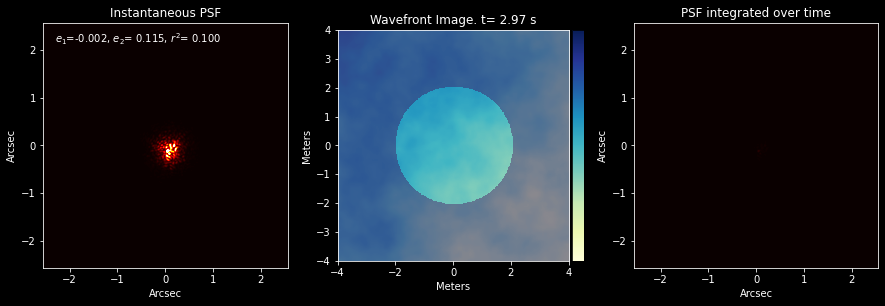

In [8]:
def create_GSO(t0,theta,lam,aper,time_step,r0_500,spd,dirn,alts,rng,screen_size,screen_scale,seed):
    #creating atmosphere layers
    rng = galsim.BaseDeviate(seed)
    atm = galsim.Atmosphere(r0_500=r0_500, speed=spd, direction=dirn, altitude=alts, rng=rng,
                            screen_size=screen_size, screen_scale=screen_scale)
    wf = atm.wavefront(aper.u, aper.v, t0, theta=theta) * 2*np.pi/lam  # radians
    psfinst = atm.makePSF(lam=lam, theta=theta, aper=aper,
                      t0=t0, exptime=time_step)
    psfintg = atm.makePSF(lam=lam, theta=theta, aper=aper,
                      t0=t0, exptime=time_step)
    
    return wf, psfinst, psfintg

def update_img(PSF, psf_nx, psf_scale, accumulate):
    #store final image
    psf_img_sum = galsim.ImageD(psf_nx, psf_nx, scale=psf_scale)
    psf_img0 = PSF.drawImage(nx=psf_nx, ny=psf_nx, scale=psf_scale)
    if accumulate:
        psf_img_sum += psf_img0
        psf_img_f = psf_img_sum/(i+1)
    else:
        psf_img_f = psf_img0
    # Calculate simple estimate of size and ellipticity
    e = galsim.utilities.unweighted_shape(psf_img0)
    
    return psf_img_f, e

for i in range(nstep):
    #create GSobjects
    wf, psfinst, psfintg = create_GSO(t0,theta,lam,aper,time_step,
                                      r0_500,spd,dirn,alts,rng,screen_size,screen_scale,seed)
    
    #draw and update images
    psf_inst_img_f, e_inst = update_img(psfinst, psf_nx, psf_scale, accumulate)
    psf_intg_img_f, e_intg = update_img(psfintg, psf_nx, psf_scale, accumulateint)
   
    # Update t0 for the next movie frame.
    t0 += time_step

    # Matplotlib code updating plot elements
    wf_im.set_array(wf)
    wf_ax.set_title("Wavefront Image. t={:5.2f} s".format(i*time_step))
    
    psf_inst_im.set_array(psf_inst_img_f.array)
    
    psf_intg_im.set_array(psf_intg_img_f.array)
    
    etext.set_text("$e_1$={:6.3f}, $e_2$={:6.3f}, $r^2$={:6.3f}".format(
            e['e1'], e['e2'], e['rsqr']*psf_scale**2))

fig   


